In [7]:
import pandas as pd
import geopandas as gpd
import googletrans
from googletrans import Translator

This notebook processes geometries for the GEDP data with two output tables:
- Admin geometries (polygons): for continents, global iso as well as China adm1; and
- Coal power plants (points)

## Admin geometries table

We'll combine Chinese provinces, countries, and continents in a single polygon table.
- Province dataset shared with us by Green Energy Foundation China.
- Countries (and derived continents) dataset from https://github.com/wri/wri-bounds

### Provinces

<AxesSubplot:>

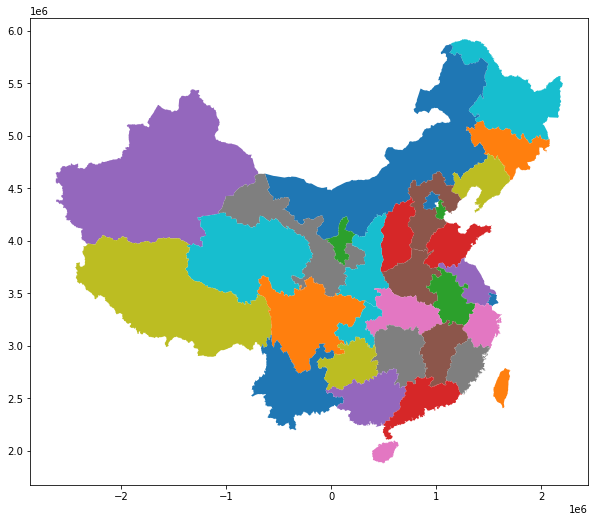

In [259]:
prov = gpd.read_file('/Users/oscaresbri/Desktop/sheng/CN-sheng-A.shp')
prov.plot(column='name', figsize=(10, 10))

In [260]:
prov

,AREA,PERIMETER,SHENG_,SHENG_ID,SHENG,name,geometry
0,4.525440e+11,6.666710e+06,2,23,23,黑龙江,"POLYGON ((1253906.366 5918214.085, 1254006.868..."
1,1.145860e+12,1.293600e+07,3,15,15,内蒙古,"POLYGON ((1136043.406 5872123.311, 1136065.406..."
2,1.631730e+12,8.745590e+06,4,65,65,新疆,"POLYGON ((-1330250.166 5440838.467, -1330231.1..."
3,1.909640e+11,4.558540e+06,5,22,22,吉林,"POLYGON ((1437824.483 5143171.371, 1437814.483..."
4,4.365380e+03,3.122740e+02,6,22,22,None,"POLYGON ((1989407.228 4890206.966, 1989402.228..."
...,...,...,...,...,...,...,...
4456,2.509440e+07,1.889610e+04,4458,46,46,None,"POLYGON ((924472.716 540040.338, 927481.767 54..."
4457,2.877420e+07,1.987630e+04,4459,46,46,None,"POLYGON ((967934.955 536356.520, 969006.973 53..."
4458,1.380340e+07,1.348390e+04,4460,46,46,None,"POLYGON ((896903.254 422551.747, 897305.261 42..."
4459,1.932580e+07,1.596860e+04,4461,46,46,None,"POLYGON ((895751.735 413410.053, 895739.734 41..."


In [261]:
print('Number of unique territory names:')
len(prov[prov['name'].notnull()]['name'].unique())

Number of unique territory names:


32

<AxesSubplot:>

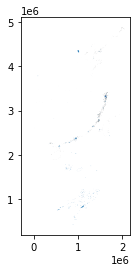

In [262]:
#plotting polygons without names assigned
prov[prov['name'].isnull()].plot()

There are 32 provinces and over 4.4k smaller polygons that we will need to assign to one of the 32 provinces.
Next step is to identify whether unique values in the column 'name' corresponde to unique id's in column 'SHENG', and which are the id's without assigned name.

In [263]:
shengid = prov[['SHENG', 'name']].copy()
shengid.drop_duplicates(inplace=True)
shengid.sort_values(by='SHENG', inplace=True)
shengid.reset_index(inplace=True, drop=True)

print('IDs without assigned names:')
for item in list(shengid[shengid['name'].isnull()]['SHENG'].unique()):
    if item not in list(shengid[shengid['name'].notnull()]['SHENG'].unique()):
        print(item)

IDs without assigned names:
81
82


In [264]:
print('Number of polygons with name-less ids:', len(prov[prov['SHENG']>80]))

Number of polygons with name-less ids: 89


In [265]:
#assign names based on id-name relationships
name_id = {}
for row in shengid.index:
    if shengid['name'][row]:
        name_id[shengid['SHENG'][row]] = shengid['name'][row]
for row in prov.index:
    if prov['SHENG'][row] in name_id.keys():
        prov.at[row, 'name'] = name_id[prov['SHENG'][row]]

In [266]:
#Dissolve all polygons with the same name into individual geometries (multipolygons)
prov = prov.dissolve(by='name', aggfunc='mean')
prov.reset_index(inplace=True)

In [269]:
prov.drop(columns=prov.keys()[2:], inplace=True)
prov.rename(columns={'name': 'region_cn'}, inplace=True)

In [339]:
my_translation = translator.translate("Cerco un centro di gravità permanente", src='it', dest='en')
print(my_translation.text)

AttributeError: 'NoneType' object has no attribute 'group'

In [331]:
prov['region_en'] = Translator.translate(text=prov['region_cn'], dest='en', src='auto')

TypeError: translate() missing 1 required positional argument: 'self'

<AxesSubplot:>

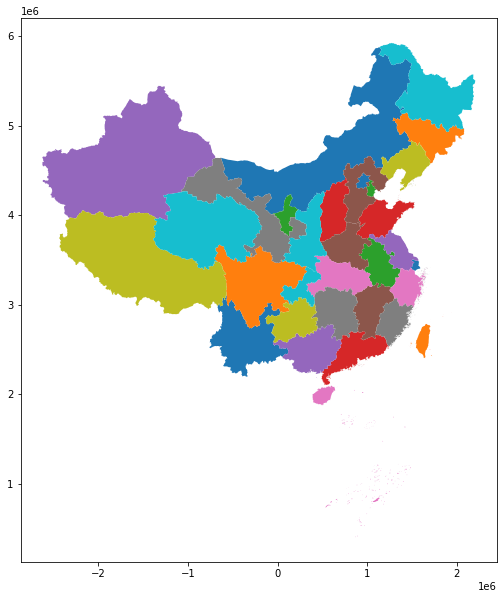

In [270]:
prov.plot(column='region_cn', figsize=(10,10))

In [150]:
prov.crs

<Projected CRS: PROJCS["Krasovsky_1940_Albers",GEOGCS["GCS_Krasovs ...>
Name: Krasovsky_1940_Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: Not specified (based on Krassowsky 1940 ellipsoid)
- Ellipsoid: Krassowsky_1940
- Prime Meridian: Greenwich

In [292]:
prov.to_crs(epsg='4326', inplace=True)

Need to confirm that islands are properly assigned to the provinces.

### Countries & Continents

In [295]:
countries = gpd.read_file('/Users/oscaresbri/Downloads/cn_countries/cn_countries.shp')

<AxesSubplot:>

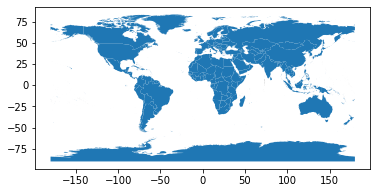

In [296]:
countries.plot()

In [297]:
countries.keys()

Index(['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3',
       'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary',
       'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es',
       'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2',
       'wb_a3', 'wb_region', 'geometry'],
      dtype='object')

In [298]:
countries.head()

,ADM0_A3,abbrev,continent,formal_nam,iso_a2,iso_a3,iso_n3,iso_short,name,name_sort,...,un_fr,un_n3,un_region,un_ru,un_subregi,un_zh,wb_a2,wb_a3,wb_region,geometry
0,ABW,Aruba,North America,Aruba,AW,ABW,533.0,Aruba,Aruba,Aruba,...,None,533.0,Americas,None,Caribbean,None,AW,ABW,Latin America & Caribbean,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,AFG,Afg.,Asia,Islamic State of Afghanistan,AF,AFG,4.0,Afghanistan,Afghanistan,Afghanistan,...,Afghanistan (l') [masc.],4.0,Asia,Афганистан,Southern Asia,阿富汗,AF,AFG,South Asia,"POLYGON ((74.89231 37.23111, 74.81314 37.21543..."
2,AGO,Ang.,Africa,People's Republic of Angola,AO,AGO,24.0,Angola,Angola,Angola,...,Angola (l') [masc.],24.0,Africa,Ангола,Middle Africa,安哥拉,AO,AGO,Sub-Saharan Africa,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,AIA,Ang.,North America,None,AI,AIA,660.0,Anguilla,Anguilla,Anguilla,...,None,660.0,Americas,None,Caribbean,None,-99,-99,Latin America & Caribbean,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,ALB,Alb.,Europe,Republic of Albania,AL,ALB,8.0,Albania,Albania,Albania,...,Albanie (l') [fém.],8.0,Europe,Албания,Southern Europe,阿尔巴尼亚,AL,ALB,Europe & Central Asia,"POLYGON ((20.06496 42.54676, 20.08563 42.53001..."


In [299]:
continents = countries.dissolve(by='continent', aggfunc='sum')
continents.drop(index='Seven seas (open ocean)', inplace=True)
continents.reset_index(inplace=True)
continents = continents[['continent', 'geometry']]
continents.rename(columns={'continent': 'region_en'}, inplace=True)

In [300]:
continents

,region_en,geometry
0,Africa,"MULTIPOLYGON (((37.864 -46.941, 37.836 -46.959..."
1,Antarctica,"MULTIPOLYGON (((-147.071 -76.076, -146.908 -76..."
2,Asia,"MULTIPOLYGON (((96.914 -12.195, 96.902 -12.200..."
3,Europe,"MULTIPOLYGON (((3.383 -54.449, 3.365 -54.462, ..."
4,North America,"MULTIPOLYGON (((-160.012 -0.382, -160.025 -0.3..."
5,Oceania,"MULTIPOLYGON (((158.866 -54.750, 158.838 -54.7..."
6,South America,"MULTIPOLYGON (((-67.568 -55.807, -67.552 -55.8..."


<AxesSubplot:>

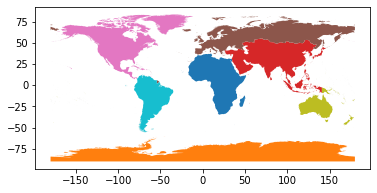

In [301]:
continents.plot(column='region_en')

Note that All of Russia is considered Europe as well as French Guyane (and probably other smaller islands)

In [302]:
continents.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [316]:
ant = continents[continents['region_en']=='Antarctica'].copy()
ant.to_crs(epsg='3031', inplace=True)

In [326]:
ant.to_file("ant_pro.geojson", driver='GeoJSON')

In [321]:
pwd

'/Users/oscaresbri/Documents/sci_team_data_bank/Projects/green-energy-data-platform/processing'

#### Ensure we have the right name ID's to cross tables

In [81]:
data = pd.read_csv('../data/Socio-economic Data/socioecon_cleanv2.csv')

In [113]:
data_c = data[data['region_type']=='Country']['Region'].unique()

In [125]:
missing = []
existing = []

for country in data_c:
    if country not in countries['name'].unique():
        missing.append(country)
    else:
        existing.append(country)

print(f"There are {len(missing)} missing countries in the geometries table and {len(existing)} existing countries")

There are 20 missing countries in the geometries table and 213 existing countries


In [122]:
not_found = ['Andreas Is. (N)', 'Bonaire', 'Canary Is.', 'Ceuta', 'French Guyana', 'Gambier Is.', 'Guadeloupe', 'Marquesas Islands',
             'Martinique', 'Mayotte', 'Melilla', 'Reunion', 'Saba', 'Society Is.', 'Taiwan, China', 'Tanzania',
             'Tuamotu Archipelago', 'Tubuai Islands',  'Virgin Is. (E)', 'Western Sahara']

ren_in_shp = {'Hong Kong': 'Hong Kong, China', 'Macao': 'Macao, China'}

count_ren = {'Bahamas': 'The Bahamas',
 'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
 'Byelorussia': 'Belarus',
 'Cayman Is.': 'Cayman Islands',
 'Central Africa': 'Central African Republic',
 'Congo': 'Republic of Congo',
 'Congo DR': 'Democratic Republic of the Congo',
 'Cook Is.': 'Cook Islands',
 "Cote d'lvoire": 'Ivory Coast',
 'Curacao': 'Curaçao',
 'Czech': 'Czech Republic',
 'Dominica Rep.': 'Dominican Republic',
 'Eq. Guinea': 'Equatorial Guinea',
 'Granada': 'Grenada',
 'Guinea-Bissau': 'Guinea Bissau',
 'Kirghizia': 'Kyrgyzstan',
 'Korea DPR': 'North Korea',
 'Korea Rep.': 'South Korea',
 'Marshall. Is.': 'Marshall Islands',
 'Micronesia Commonwealth': 'Federated States of Micronesia',
 'Moldavia': 'Moldova',
 'New Caledonia (Fr)': 'New Caledonia',
 'Norfolk Islands': 'Norfolk Island',
 'North Macedonia': 'Macedonia',
 'P. R. China': 'China',
 'Polynesia (F)': 'French Polynesia',
 'Republic of South Sudan': 'South Sudan',
 'Russian Federation': 'Russia',
 'Saint Martin Is.': 'Saint Martin',
 'Saint Vincent & Grenadines': 'Saint Vincent and the Grenadines',
 'Sao Tome & Principe': 'Sao Tome and Principe',
 'Serbia': 'Republic of Serbia',
 'Slovak': 'Slovakia',
 'Solomon Is.': 'Solomon Islands',
 'St. Kitts-Nevis': 'Saint Kitts and Nevis',
 'St. Pierre and Miquelon': 'Saint Pierre and Miquelon',
 'Surinam': 'Suriname',
 'Tadzhikistan': 'Tajikistan',
 'Timor Leste': 'Timor-Leste',
 'Turks & Caicos Is.': 'Turks and Caicos Islands',
 'United States': 'United States of America',
 'Vatican City State': 'Vatican'}

In [228]:
data.replace({'Region': count_ren}, inplace = True)
countries.replace({'name': ren_in_shp}, inplace = True)

## Coal Power Plants

Plant coordinates included in the coal power plants dataset

In [234]:
plants = pd.read_csv('../data/plants_clean.csv')
plants.rename(columns={'plant_chi': 'region_cn', 'plant': 'region_en'}, inplace=True)

In [238]:
len(plants['region_cn'].unique())

1290

In [239]:
print('List of plants without English name:')
sorted(list(plants[plants['region_en']=='No name']['region_cn'].unique()))

List of plants without English name:


['万基控股洛阳义安电力公司',
 '东糖集团三联热电',
 '中国平煤神马集团坑口电厂',
 '中铝华宇铝电',
 '义煤集团义马铬渣发电厂',
 '兖矿集团科澳铝业南屯发电厂',
 '凯迪电力蓝光发电厂',
 '华润洛阳环保能源公司',
 '华润电力宜兴热电公司',
 '华电吐鲁番发电公司一期',
 '华电新疆喀什热电公司二期',
 '华能塔什店发电厂四期',
 '四川其亚铝业集团乐山海虹发电公司',
 '国家电投绥阳化绥阳化工公司热电厂',
 '国投北部湾发电公司北海电厂一期',
 '国电宿迁热电公司一期',
 '大唐国际抚州发电厂新建项目一期',
 '大唐国际甘肃连城发电公司',
 '大唐徐塘发公司一期',
 '大唐徐塘发电公司三期',
 '大唐甘肃甘谷发电厂',
 '大连红海发电厂',
 '天富集团石河子天富东发电厂',
 '天富集团石河子天富南热电一期',
 '天富集团石河子天富西发电厂',
 '山东海化集团潍坊热电公司扩建项目',
 '川煤攀煤煤矸石发电厂',
 '常州中天钢铁有限责任公司',
 '建晖纸业东莞自备电厂',
 '新疆天业自备电厂天辰电厂',
 '武汉蓝翔电厂',
 '河南投资集团郑州新力电力公司',
 '玖龙纸业东莞自备电厂',
 '理文造纸东莞自备电厂',
 '神华国华九江发电公司',
 '神华国能宁鲁煤电灵州发电厂一期',
 '金田纸业东莞自备电厂',
 '阳煤国泰新华煤基精细化工项目自备电厂',
 '陕煤化神木能源发展公司洁能发电厂',
 '陕西三秦能源群生发电厂',
 '魏桥集团沾化煤粉灰综合利用能源分厂']

In [240]:
plants = plants[plants.keys()[1:5]].copy()
plants.drop_duplicates(inplace=True)
plants.reset_index(inplace=True)

In [241]:
print('Unique lat-lon-name_cn-name_en combinations:', len(plants))
print('Unique lat-lon combinations:', len(plants[['latitude', 'longitude']].drop_duplicates()))
print('')
print(f"There's {len(plants)-len(plants[['latitude', 'longitude']].drop_duplicates())} instances where given coordinates are assigned multiple plant names.")

Unique lat-lon-name_cn-name_en combinations: 1323
Unique lat-lon combinations: 1171

There's 152 instances where given coordinates are assigned multiple plant names.


In [242]:
#convert df to geodataframe
plants_gdf = gpd.GeoDataFrame(
    plants, geometry=gpd.points_from_xy(plants.longitude, plants.latitude))
plants_gdf = plants_gdf.set_crs(epsg=4326)

In [243]:
plants_gdf.drop(columns=['latitude', 'longitude'], inplace=True)

no name_en in orange


<AxesSubplot:>

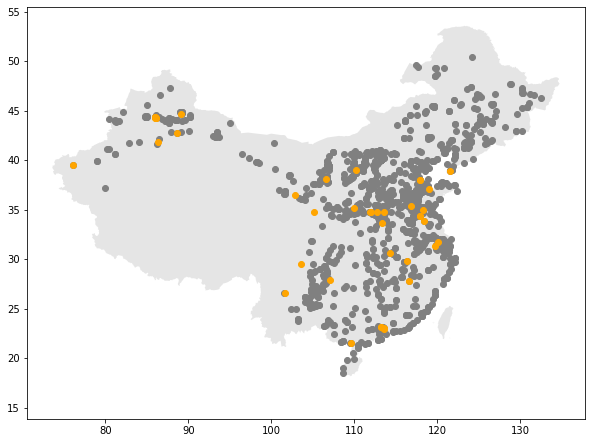

In [244]:
print('no name_en in orange')
plantsplot = countries[countries['name']=='China'].plot(figsize=(10,10), color = 'grey', alpha=0.2)
plants_gdf[plants_gdf['region_en']!='No name'].plot(color='grey', ax=plantsplot)
plants_gdf[plants_gdf['region_en']=='No name'].plot(ax=plantsplot, color='orange')

In [229]:
plants_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [290]:
plants_gdf.to_crs(epsg='4326', inplace=True)
plants_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
import google_trans_new

In [27]:
from google_trans_new import google_translator  
translator = google_translator()  


社会经济
